# Classification With Transformers

In [109]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential, load_model

In [110]:
data_train = pd.read_csv("aapl_5m_train.csv").dropna()
data_test = pd.read_csv("aapl_5m_test.csv").dropna()

In [111]:
data_train.head()

,Unnamed: 0,Timestamp,Gmtoffset,Datetime,Open,High,Low,Close,Volume
0,0,1609770600,0,2021-01-04 14:30:00,133.570007,133.611602,132.389999,132.809997,6624663.0
1,1,1609770900,0,2021-01-04 14:35:00,132.750000,132.750000,131.809997,131.889999,2541553.0
2,2,1609771200,0,2021-01-04 14:40:00,131.500000,132.339996,131.500000,132.059997,2492415.0
3,3,1609771500,0,2021-01-04 14:45:00,132.000000,132.250000,131.899993,132.250000,1859131.0
4,4,1609771800,0,2021-01-04 14:50:00,132.000000,132.018096,131.520004,131.589996,1780105.0


## Normalizing Data

In [112]:
train_mean = data_train.loc[:, ["Open", "High", "Low", "Close"]].mean()
train_std = data_train.loc[:, ["Open", "High", "Low", "Close"]].std()

norm_data_train = (data_train.loc[:, ["Open", "High", "Low", "Close"]] - train_mean) / train_std
norm_data_test = (data_test.loc[:, ["Open", "High", "Low", "Close"]] - train_mean) / train_std

## Generating our features

In [113]:
lags = 5

X_train = pd.DataFrame()
X_test = pd.DataFrame()

for lag in range(lags):
    X_train[f"Open_{lag}"] = norm_data_train.Open.shift(lag)
    X_train[f"High_{lag}"] = norm_data_train.High.shift(lag)
    X_train[f"Low_{lag}"] = norm_data_train.Low.shift(lag)
    X_train[f"Close_{lag}"] = norm_data_train.Close.shift(lag)
    
    X_test[f"Open_{lag}"] = norm_data_test.Open.shift(lag)
    X_test[f"High_{lag}"] = norm_data_test.High.shift(lag)
    X_test[f"Low_{lag}"] = norm_data_test.Low.shift(lag)
    X_test[f"Close_{lag}"] = norm_data_test.Close.shift(lag)

Y_train = (X_train.Close_0 * (1 + 0.01) < X_train.Close_0.shift(-1)).astype(float)
Y_test = (X_test.Close_0 * (1 + 0.01) < X_test.Close_0.shift(-1)).astype(float)

# Removing nans and last value
X_train = X_train.iloc[5:-1, :].values
X_test = X_test.iloc[5:-1, :].values

Y_train = Y_train.iloc[5:-1].values.reshape(-1, 1)
Y_test = Y_test.iloc[5:-1].values.reshape(-1, 1)

## Reshaping Tensors

In [114]:
features = X_train.shape[1]

X_train = X_train.reshape(-1, features, 1)
X_test = X_test.reshape(-1, features, 1)

## Classification Model

In [115]:
def create_transformer(inputs, head_size, num_heads, dnn_dim):
    # Stacking layers
    l1 = tf.keras.layers.MultiHeadAttention(key_dim=head_size,
                                            num_heads=num_heads,
                                            dropout=0.2)(inputs, inputs)
    l2 = tf.keras.layers.Dropout(0.2)(l1)
    l3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(l2)
    
    res = l3 + inputs
    
    # Traditional DNN
    l4 = tf.keras.layers.Conv1D(filters=4, kernel_size=1, activation="relu")(res)
    l5 = tf.keras.layers.Dropout(0.2)(l4)
    l6 = tf.keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(l5)
    l7 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(l6)
    return l7 + res

In [116]:
input_shape = X_train.shape[1:]

# Hyperparams
head_size = 256
num_heads = 4
num_transformer_blocks = 4
dnn_dim = 4
units = 128


# Defining input_shape as Input layer
input_layer = tf.keras.layers.Input(input_shape)

# Creating our transformers based on the input layer
transformer_layers = input_layer

for _ in range(num_transformer_blocks):
    # Stacking transformers
    transformer_layers = create_transformer(inputs=transformer_layers,
                                            head_size=head_size,
                                            num_heads=num_heads,
                                            dnn_dim=dnn_dim)

# Adding global pooling
pooling_layer = tf.keras.layers.GlobalAveragePooling1D(data_format="channels_last")\
                                                      (transformer_layers)

# Adding MLP layers
l1 = tf.keras.layers.Dense(units=128, activation="leaky_relu")(pooling_layer)
l2 = tf.keras.layers.Dropout(0.3)(l1)
l3 = tf.keras.layers.Dense(units=128, activation="leaky_relu")(l2)

# Last layer, units = 2 for True and False values
outputs = tf.keras.layers.Dense(units=2, activation="softmax")(l3)

# Model
model = tf.keras.Model(inputs=input_layer,
                       outputs=outputs,
                       name="transformers_classification")

metric = tf.keras.metrics.SparseCategoricalAccuracy()
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
callbacks = [tf.keras.callbacks.EarlyStopping(monitor="loss",
                                              patience=10,
                                              restore_best_weights=True)]

In [117]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=adam_optimizer,
    metrics=[metric],
)

In [118]:
model.summary()

Model: "transformers_classification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)    │ (None, 20, 1)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_16       │ (None, 20, 1)             │           7,169 │ input_layer_8[0][0],       │
│ (MultiHeadAttention)          │                           │                 │ input_layer_8[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_53 (Dropout)          │ (None, 20, 1)             │               0 │ multi_head_attention_16[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_32        │ (None, 20, 1)             │               2 │ dropout_53[0][0]           │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_32 (Add)                  │ (None, 20, 1)             │               0 │ layer_normalization_32[0]… │
│                               │                           │                 │ input_layer_8[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_32 (Conv1D)            │ (None, 20, 4)             │               8 │ add_32[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_54 (Dropout)          │ (None, 20, 4)             │               0 │ conv1d_32[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_33 (Conv1D)            │ (None, 20, 1)             │               5 │ dropout_54[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_33        │ (None, 20, 1)             │               2 │ conv1d_33[0][0]            │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_33 (Add)                  │ (None, 20, 1)             │               0 │ layer_normalization_33[0]… │
│                               │                           │                 │ add_32[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_17       │ (None, 20, 1)             │           7,169 │ add_33[0][0], add_33[0][0] │
│ (MultiHeadAttention)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_56 (Dropout)          │ (None, 20, 1)             │               0 │ multi_head_attention_17[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_34        │ (None, 20, 1)             │               2 │ dropout_56[0][0]           │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_34 (Add)                  │ (None, 20, 1)             │               

 Total params: 45,770 (178.79 KB)

 Trainable params: 45,770 (178.79 KB)

 Non-trainable params: 0 (0.00 B)

In [119]:
model.fit(
    X_train,
    Y_train,
    epochs=10,
    batch_size=64,
    callbacks=callbacks,
)

Epoch 1/10
612/612 ━━━━━━━━━━━━━━━━━━━━ 28s 29ms/step - loss: 0.5824 - sparse_categorical_accuracy: 0.6958
Epoch 2/10
612/612 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - loss: 0.5412 - sparse_categorical_accuracy: 0.7231
Epoch 3/10
612/612 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - loss: 0.5421 - sparse_categorical_accuracy: 0.7217
Epoch 4/10
612/612 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - loss: 0.5398 - sparse_categorical_accuracy: 0.7239
Epoch 5/10
612/612 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - loss: 0.5488 - sparse_categorical_accuracy: 0.7180
Epoch 6/10
612/612 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - loss: 0.5448 - sparse_categorical_accuracy: 0.7188
Epoch 7/10
612/612 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - loss: 0.5483 - sparse_categorical_accuracy: 0.7170
Epoch 8/10
612/612 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - loss: 0.5423 - sparse_categorical_accuracy: 0.7183
Epoch 9/10
612/612 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - loss: 0.5421 - sparse_categorical_accuracy: 0.7204
Epoch 10/10
612/612 ━━━━━━━━━━━━━━━━━

In [120]:
model.save("transformer_classifier.keras")

In [121]:
del model

In [134]:
# Load model
model = load_model("transformer_classifier.keras")

In [135]:
y_hat_train = model.predict(X_train)

1224/1224 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step


In [136]:
model.evaluate(X_train, Y_train)

1224/1224 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.4904 - sparse_categorical_accuracy: 0.7719


[0.5445749163627625, 0.7184451222419739]

In [137]:
model.evaluate(X_test, Y_test)

607/607 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.4601 - sparse_categorical_accuracy: 0.7790


[0.31310927867889404, 0.8703780174255371]

In [138]:
y_hat_test = model.predict(X_test)

607/607 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step


In [139]:
trading_data = data_test.iloc[5:-1, :]
trading_data["BUY_SIGNAL"] = y_hat_test.argmax(axis=1).astype(bool)

C:\Users\juana\AppData\Local\Temp\ipykernel_17960\3217088435.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trading_data["BUY_SIGNAL"] = y_hat_test.argmax(axis=1).astype(bool)


In [140]:
trading_data

,Timestamp,Gmtoffset,Datetime,Open,High,Low,Close,Volume,BUY_SIGNAL
5,1672757700,0,2023-01-03 14:55:00,127.879997,127.980003,126.879997,126.933601,2142452.0,True
6,1672758000,0,2023-01-03 15:00:00,126.940002,127.300003,126.416603,126.500099,2008892.0,True
7,1672758300,0,2023-01-03 15:05:00,126.504997,126.894996,126.440002,126.480003,1467417.0,True
8,1672758600,0,2023-01-03 15:10:00,126.474998,126.500000,125.780097,125.915000,2186455.0,True
9,1672758900,0,2023-01-03 15:15:00,125.919998,126.055000,125.489997,125.519996,1769361.0,True
...,...,...,...,...,...,...,...,...,...
19672,1703881800,0,2023-12-29 20:30:00,192.675003,192.759994,192.634994,192.639999,720526.0,False
19673,1703882100,0,2023-12-29 20:35:00,192.639999,192.720001,192.630004,192.634994,333590.0,False
19674,1703882400,0,2023-12-29 20:40:00,192.634994,192.695007,192.470001,192.500000,458428.0,False
19675,1703882700,0,2023-12-29 20:45:00,192.505004,192.589996,192.490005,192.510299,443450.0,False


## Backtesting

In [141]:
capital = 1_000_000
n_shares = 50
stop_loss = 0.10
take_profit = 0.10

COM = 0.125 / 100

active_positions = []
portfolio_value = [capital]

for i, row in trading_data.iterrows():
    # Close all positions that are above/under tp or sl
    active_pos_copy = active_positions.copy()
    for pos in active_pos_copy:
        if row.Close < pos["stop_loss"]:
            # LOSS
            capital += row.Close * pos["n_shares"] * (1 - COM)
            active_positions.remove(pos)
        if row.Close > pos["take_profit"]:
            # PROFIT
            capital += row.Close * pos["n_shares"] * (1 - COM)
            active_positions.remove(pos)

    # Check if trading signal is True
    if row.BUY_SIGNAL:
        # Check if we have enough cash
        if capital > row.Close * (1 + COM) * n_shares:
            capital -= row.Close * (1 + COM) * n_shares
            active_positions.append({
                "type": "LONG",
                "bought_at": row.Close,
                "n_shares": n_shares,
                "stop_loss": row.Close * (1 - stop_loss),
                "take_profit": row.Close * (1 + take_profit)
            })
        else:
            print("OUT OF CASH")
    
    # Portfolio value through time
    positions_value = len(active_positions) * n_shares * row.Close
    portfolio_value.append(capital + positions_value)

# Close all positions that are above/under tp or sl
active_pos_copy = active_positions.copy()
for pos in active_pos_copy:
    capital += row.Close * pos["n_shares"] * (1 - COM)
    active_positions.remove(pos)

portfolio_value.append(capital)

OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT 

In [142]:
capital_benchmark = 1_000_000
shares_to_buy = capital_benchmark // (trading_data.Close.values[0] * (1 + COM))
capital_benchmark -= shares_to_buy * trading_data.Close.values[0] * (1 + COM)
portfolio_value_benchmark = (shares_to_buy * trading_data.Close) + capital_benchmark

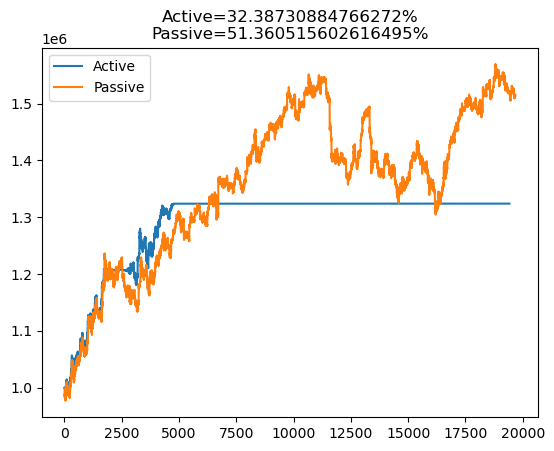

In [143]:
plt.title(f"Active={(portfolio_value[-1] / 1_000_000 - 1)*100}%\n" + 
          f"Passive={(portfolio_value_benchmark.values[-1] / 1_000_000 - 1)*100}%")
plt.plot(portfolio_value, label="Active")
plt.plot(portfolio_value_benchmark, label="Passive")
plt.legend()
plt.show()

In [144]:
print("asd")

asd


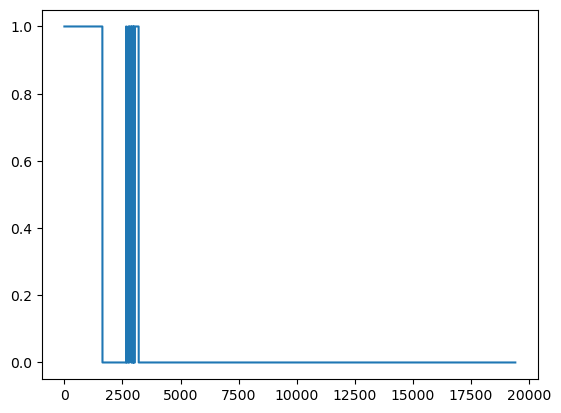

In [145]:
plt.plot(trading_data["BUY_SIGNAL"].values.astype(int))